<a href="https://colab.research.google.com/github/mimingucci/ML/blob/main/DecisionTreeRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [4]:
tips=sns.load_dataset('tips')
print(tips)
x=np.array(tips.drop(columns='tip'))
y=np.array(tips['tip'])

     total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]


In [5]:
test_sz=int(len(y)*0.2)
x_test=x[:test_sz]
y_test=y[:test_sz]
x_train=x[test_sz:]
y_train=y[test_sz:]

In [6]:
def rss_reduction(parent, left, right):
  p=sum((parent-np.mean(parent))**2)
  l=sum((left-np.mean(left))**2)
  r=sum((right-np.mean(right))**2)
  return p-(l+r)

In [7]:
def sort_x_by_y(x, y):
  unique_xs=np.unique(x)
  y_mean_by_per_x=[(y[x==i]).mean() for i in unique_xs]
  return unique_xs[np.argsort(y_mean_by_per_x)]

In [8]:
def all_nodes_in_same_depth_equal(x):
  return (x==x[0]).all()

In [9]:
class Node:
    def __init__(self, xsub, ysub, ID, depth = 0, parent_ID = None, leaf = True):
        self.ID = ID
        self.x = xsub
        self.y = ysub
        self.size = len(ysub)
        self.depth = depth
        self.parent_ID = parent_ID
        self.leaf = leaf

In [10]:
class Splitter:
    def __init__(self):
        self.rss_reduction = 0
        self.no_split = True

    def change_split_way(self, rss_reduction, d, dtype = 'quant', t = None, L_values = None):
        self.rss_reduction = rss_reduction
        self.d = d
        self.dtype = dtype
        self.t = t
        self.left_child_values = L_values
        self.no_split = False

In [24]:
class DecisionTreeRegression:
  def fit(self, x, y, max_depth = 100, min_size = 2, C = None):
      self.x=x
      self.y=y
      self.N, self.D=self.x.shape
      dt=[np.array(list(self.x[:, d])).dtype for d in range(self.D)]
      self.dtypes=['quant' if (d==int or d==float) else 'cat' for d in dt]
      self.max_depth = max_depth
      self.min_size = min_size
      self.C = C
      self.nodes = {}
      self.current_ID = 0
      root_node = Node(xsub = x, ysub = y, ID = self.current_ID, parent_ID = None)
      self.nodes[self.current_ID] = root_node
      self.current_ID += 1
  def build(self):
      buds=self.nodes
      for layer in range(self.max_depth):
          buds={id:node for (id, node) in self.nodes.items() if (node.leaf==True) & (node.size>=self.min_size) & (~all_nodes_in_same_depth_equal(node.x)) & (len(np.unique(node.y))>1)}
          if(len(buds)==0):
            break
          for id, node in buds.items():
            self.find_split_way()
            if self.splitter.no_split==False:
              self.make_split()

  def find_split_way(self, bud):
      splitter=Splitter()
      splitter.id=bud.ID
      if self.C is None:
        predictors=np.arange(self.D)
      else:
        predictors=np.random.choice(np.arange(self.D), self.C, replace=False)

      for i in sorted(predictors):
        xsub=bud.x[:, i]
        dtype=self.dtypes[i]
        if(len(np.unique(xsub))==1):
          continue
        if dtype=='quant':
          for t in np.unique(xsub)[:-1]:#except last one
             y_left=bud.y[x<=t]
             y_right=bud.y[x>t]
             rss=rss_reduction(bud.y, y_left, y_right)
             if rss>splitter.rss_reduction:
              splitter.change_split_way(rss, d=i, dtype='quant', t=t)
        else:
          x_order_by_y=sort_x_by_y(xsub, bud.y)
          for j in range(len(x_order_by_y)-1):
            left_child_values=x_order_by_y[:j+1]
            left=bud.y[np.isin(xsub, left_child_values)]
            right=bud.y[~np.isin(xsub, left_child_values)]
            rss=rss_reduction(bud.y, left, right)
            if rss>splitter.rss_reduction:
              splitter.change_split_way(rss, i, 'con', L_values=left_child_values)
      #save
      self.splitter=splitter

  def make_split(self):
    # Update parent node
    parent_node = self.nodes[self.splitter.id]
    parent_node.leaf = False
    parent_node.child_left_id = self.current_ID
    parent_node.child_right_id = self.current_ID + 1
    parent_node.d = self.splitter.d
    parent_node.dtype = self.splitter.dtype
    parent_node.t = self.splitter.t
    parent_node.left_child_values = self.splitter.left_child_values

    if parent_node.dtype == 'quant':
        L_condition = parent_node.x[:,parent_node.d] <= parent_node.t
    else:
        L_condition = np.isin(parent_node.x[:,parent_node.d], parent_node.left_child_values)
    xchild_L = parent_node.x[L_condition]
    ychild_L = parent_node.y[L_condition]
    xchild_R = parent_node.x[~L_condition]
    ychild_R = parent_node.y[~L_condition]


    # Create child nodes
    left_child_node = Node(xchild_L, ychild_L, depth = parent_node.depth + 1,
                        ID = self.current_ID, parent_ID = parent_node.ID)
    right_child_node = Node(xchild_R, ychild_R, depth = parent_node.depth + 1,
                        ID = self.current_ID+1, parent_ID = parent_node.ID)
    self.nodes[self.current_ID] = left_child_node
    self.nodes[self.current_ID + 1] = right_child_node
    self.current_ID += 2

  def get_leaf_means(self):
    self.leaf_means = {}
    for id, node in self.nodes.items():
        if node.leaf:
            self.leaf_means[id] = node.y.mean()


  ####### PREDICT ########
  def predict(self, X_test):

    # Calculate leaf means
    self.get_leaf_means()

    yhat = []
    for x in X_test:
        node = self.nodes[0] # here we are root node
        while not node.leaf:
            if node.dtype == 'quant':
                if x[node.d] <= node.t:
                    node = self.nodes[node.child_left_id]
                else:
                    node = self.nodes[node.child_right_id]
            else:
                if x[node.d] in node.left_child_values:
                    node = self.nodes[node.child_left_id]
                else:
                    node = self.nodes[node.child_right_id]
        yhat.append(self.leaf_means[node.ID])
    return np.array(yhat)


In [25]:
tree=DecisionTreeRegression()
tree.fit(x_train, y_train, max_depth=7, min_size=5)
y_predict=tree.predict(x_test)
print(y_predict)

[2.97015306 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306
 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306
 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306
 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306
 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306
 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306
 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306
 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306 2.97015306]


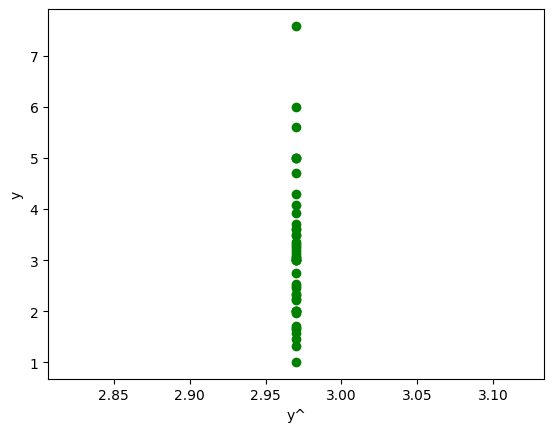

In [ ]:
plt.scatter(y_predict, y_test, c='green')
plt.xlabel('y^')
plt.ylabel('y')
plt.show()